## Text Classification and Prediction: What's Cooking
S. Michael

This notebook trains a classifier to predict the cuisine type on a test set containing the ingredients of a list of recipes.

Data Source: https://www.kaggle.com/competitions/whats-cooking/data

Steps:
1. Imports nececessary libraries
2. Downloads and reads Kaggles' 'whats-cooking.zip' data
3. Explores the train and test data sets
4. Preprocesses the data
5. Transforms Data (one-hot encode & handle imbalanced data)
6. TF-IDF for Feature Extraction & the LinearSVC Classifier
8. Assess Model Performance on Validation Data
10. Predicts the cusines of a list of recipes from the data set, test

### Import Libraries

In [41]:
#download & read data
import os
#!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

#explore data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#preprocess data
import re
from nltk import WordNetLemmatizer

#transform data
from sklearn.preprocessing import LabelEncoder
import imblearn
from imblearn import under_sampling
from collections import Counter

#tokenize & extract features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
#!pip install mlxtend
from mlxtend.feature_selection import ColumnSelector

#apply classifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

### Download Kaggle What's Cooking Data

In [2]:
!mkdir ~/.kaggle
!echo '{"username":"sherylmichael","key":"c75f8d530e0af74d13b7420065cc474b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/sherilyn/.kaggle: File exists


In [3]:
#download Kaggle data set
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

api = KaggleApi()
api.authenticate()

print(api.competition_list_files('whats-cooking'))
api.competition_download_files('whats-cooking')

[test.json.zip, train.json.zip, sample_submission.csv.zip]


In [4]:
# Read train & test data
ZipFile('whats-cooking.zip').extractall('data')
ZipFile('data/test.json.zip').extractall('data')
ZipFile('data/train.json.zip').extractall('data')

In [5]:
train = pd.read_json('data/train.json')
test = pd.read_json('data/test.json')

### Exploring Data

In [6]:
print("train shape:", train.shape)
train.head()

train shape: (39774, 3)


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [7]:
# check for missing data train
train.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

In [8]:
# summarize distribution train
train.cuisine.value_counts()

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

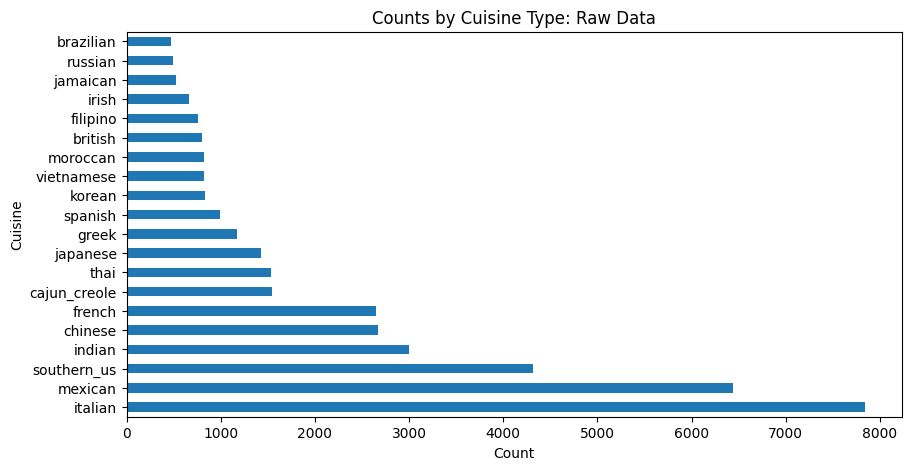

In [9]:
#plot distribution train
train.cuisine.value_counts().plot.barh(figsize = (10,5))
plt.title('Counts by Cuisine Type: Raw Data')
plt.xlabel('Count')
plt.ylabel('Cuisine')
plt.show()

In [10]:
print("test shape:", test.shape)
test.head()

test shape: (9944, 2)


,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [11]:
# check for missing data test
test.isnull().sum()

id             0
ingredients    0
dtype: int64

##### Summary of datasets: train, test

train is a labeled dataset with 3 columns (id, cuisiine, ingredients) and 39774 rows. train has no missing data.
test is a labeled dataset with 2 columns (id, ingredients) and 9944 rows. test has no missing data.

Exploration of train's class distribution suggests that the number of observations in each cuisine class is imbalanced.
Machine learning algorithms are often biased towards the majority class, not taking the data distribution into consideration. Minority classes may be treated as outliers and ignored.

The imbalanced data will be handled in the step, Transforming Data.

### Preprocess Data

To make it easier for the machine learning model to understand and process whats-cooking data, the data will be cleaned and standardized. 
Looking at the ingredients' list, it is a pretty clean data set. 

Thus, preprcessing data will include:
Cleaning & preprocessing train & test (i.e. converting the ingredients list to a string, removing unnecessary characters and punctuation and lemmatization)

##### Cleaning & Preprocessing train & test

In [12]:
# cleaning ingredients_str (train & test)
def lemmetize(ingredients):
    regex = "[^A-Za-z]"
    text = [WordNetLemmatizer().lemmatize(re.sub(regex,"",x).lower()) for x in ingredients]
    text = ' '.join(text)
    return text

train['ingredients_lem'] = train['ingredients'].apply(lemmetize)
test['ingredients_lem'] = test['ingredients'].apply(lemmetize)

In [13]:
train.head()

,id,cuisine,ingredients,ingredients_lem
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romainelettuce blackolives grapetomatoes garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plainflour groundpepper salt tomato groundblac...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonaise cookingoil greenchil...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetableoil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",blackpepper shallot cornflour cayennepepper on...


In [14]:
train.drop('ingredients', axis=1, inplace=True) 
test.drop('ingredients', axis=1, inplace=True)
train.head()

,id,cuisine,ingredients_lem
0,10259,greek,romainelettuce blackolives grapetomatoes garli...
1,25693,southern_us,plainflour groundpepper salt tomato groundblac...
2,20130,filipino,egg pepper salt mayonaise cookingoil greenchil...
3,22213,indian,water vegetableoil wheat salt
4,13162,indian,blackpepper shallot cornflour cayennepepper on...


In [15]:
test.head()

,id,ingredients_lem
0,18009,bakingpowder egg allpurposeflour raisin milk w...
1,28583,sugar eggyolks cornstarch creamoftartar banana...
2,41580,sausagelinks fennelbulb frond oliveoil cubanpe...
3,29752,meatcuts filepowder smokedsausage okra shrimp ...
4,35687,groundblackpepper salt sausagecasings leek par...


### Transform Data

Data transofromation will include:
1. One-hot encode cuisine data
2. RandomUnderSampler

Note: data set was too large for my laptop's capacity when applied Random Over-Sampling with imblearn to balance train's class distribution by increasing the data samples in the minority classes to match that of the majority class, 'italian.'

In [16]:
#one-hot encode cuisine column
le=LabelEncoder()
le.fit(train.cuisine)
#print('LabelEncoder() classes: ', le.classes_)
print('LabelEncoder() mapping: ', dict(zip(le.classes_, le.transform(le.classes_))))
print('\nnumber of cuisine types: ', len(le.classes_))
train['cuisine_id'] = le.transform(train.cuisine)
# split into input and output elements
X, y = train[['id', 'ingredients_lem']], train['cuisine_id']
# handle imbalanced data
#ros = over_sampling.RandomOverSampler(random_state=416)
rus = under_sampling.RandomUnderSampler(random_state=416)
#fit predictor and target variable
#X_train_oversampled, y_train_oversampled = ros.fit_resample(X, y)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X, y)

print('\nOriginal dataset shape', Counter(y))
print('\nUndersample dataset shape', Counter(y_train_undersampled))

LabelEncoder() mapping:  {'brazilian': 0, 'british': 1, 'cajun_creole': 2, 'chinese': 3, 'filipino': 4, 'french': 5, 'greek': 6, 'indian': 7, 'irish': 8, 'italian': 9, 'jamaican': 10, 'japanese': 11, 'korean': 12, 'mexican': 13, 'moroccan': 14, 'russian': 15, 'southern_us': 16, 'spanish': 17, 'thai': 18, 'vietnamese': 19}

number of cuisine types:  20

Original dataset shape Counter({9: 7838, 13: 6438, 16: 4320, 7: 3003, 3: 2673, 5: 2646, 2: 1546, 18: 1539, 11: 1423, 6: 1175, 17: 989, 12: 830, 19: 825, 14: 821, 1: 804, 4: 755, 8: 667, 10: 526, 15: 489, 0: 467})

Undersample dataset shape Counter({0: 467, 1: 467, 2: 467, 3: 467, 4: 467, 5: 467, 6: 467, 7: 467, 8: 467, 9: 467, 10: 467, 11: 467, 12: 467, 13: 467, 14: 467, 15: 467, 16: 467, 17: 467, 18: 467, 19: 467})


While overfitting for oversampled data may be a concern, my laptop does not have the computational capacity to fit oversampled data.
Because loss of information in the undersampled data is possible, the imbalanced data will be used for training.

### TF-IDF for Feature Extraction & the LinearSVC Classifier

The text needs to be transformed into vectors so machine learning algorithms will be able to make predictions. 

Term Frequency – Inverse Document Frequency (TF_IDF) accounts for the importace of each word (ingredient) in the text (list of recipes).
This notebook uses TF_IDF to perform both tokenization and feature extraction of X_train_balanced.ingredients_lem. The TF_IDF weight evaluates how important an ingredient is to each recipe in the collection. 

The TfidfVectorizer learns ingredient vocabulary and inverse document frequencies across the recipes in the feature set and then transforms (encodes) them into numerical features or vectors.

The Linear Support Vector Classifier (LinearSVC) will be used to fit the imbalanced training data.

In [25]:
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=416)

clf = Pipeline(steps=[
('col_selector', ColumnSelector(cols=('ingredients_lem'),drop_axis=True)),
('tfidf', TfidfVectorizer()),
('linsvc', LinearSVC(dual='auto'))
])

# train & assess model performance on val data
#imbalanced data
clf.fit(X_train,y_train)

print('validation accuracy: ')
clf.score(X_val, y_val)

validation accuracy: 


0.793463230672533

### Assess Model Performance on Validation Data

The Linear SVC model yielded an accuracy score of 79% on the validation data.

### Predict Test Data

In [37]:
y_pred = clf.predict(test)
print(len(y_pred))
print(len(test.id))

9944
9944


In [38]:
d = pd.DataFrame({'id': test.id, 'label': y_pred}).to_csv("whats_cooking_submission.csv", index=False)

### Kaggle Submission Results

"error - after deadline

### Further Work:

1. Explore Pipeline to include preprocessing and transformations (one-hot encode, label encoder)
2. Explore feature extraction strategies